In [1]:
%jsroot off

# Population pyramid parametrization
For the sake of simplicity, males and females are assumed to be evenly distributed among all ages, *i.e.* the population pyramid is assumed to be gender-symmetric.  
The pyramid is parametrized with a piecewise linear function, for ages ($x$) between 0 and 100 years:

$$
\mathrm{Pop}(x) = \begin{cases}
m_{1}x, & 0 \leq x < x_{1} \\
m_{2}x+q_{2}, & x_{1} \leq x < x_{2} \\
\cdots, & \cdots \\
m_{n}(x-100), & x_{n-1} \leq x \leq 100
\end{cases}
$$

The pyramid can be defined by specifying pairs $\{ \mathrm{age}, \mathrm{weight} \} = \{ a_{i}, w_{i} \}$, in ascending order of age (*i.e.* $a_{i+1} > a_{i}$ for all pairs), where $w_{i}$ is the relative importance of the given age with respect to the other given ages.  
For example: $\{ 5, 1 \}$ and $\{ 50, 2 \}$ specifies a pyramid in which people of age 50 are twice more abundant than people of age 5.  

Requiring $\mathrm{Pop}(a_{i}) = w_{i}$ and continuity at all $x = a_{i}$, we can find the values of the parameters $m_{i}$ and $q_{i}$.  
In the general case of $n$ pairs $\{ a_{i}, w_{i} \}$, there are $n+1$ straight-line segments.  
Let $a_{0} = w_{0} = w_{n} = 0$, $a_{n+1} = 100$.
Then, for $1 \leq i \leq n$, $m_{i} = (w_{i}-w_{i-1})/(a_{i}-a_{i-1})$, $q_{i} = (w_{i-1}a_{i} - w_{i}a_{i-1})/(a_{i}-a_{i-1})$, and the normalization is $(1/2)\sum_{i=1}^{n}w_{i}(a_{i+1}-a_{i-1})$.

## Derivation details
One pair $\{ a_{1}, w_{1} \}$ defines two straight-line segments:

$$
\mathrm{Pop}(x) = \begin{cases}
m_{1}x, & 0 \leq x < a_{1} \\
m_{2}(x-100), & a_{1} \leq x \leq 100
\end{cases}
$$

Requiring $\mathrm{Pop}(a_{1}) = w_{1}$ we get $m_{1}a_{1} = w_{1}$, whence $m_{1} = w_{1}/a_{1}$.  
Continuity in $x = a_{1}$ requires $m_{1}a_{1} = m_{2}(a_{1}-100)$, whence $m_{2} = m_{1}a_{1}/(a_{1}-100) = w_{1}/(a_{1}-100)$.  
The normalization of the distribution is $\int_{0}^{100}\mathrm{Pop}(x)\,dx = 
m_{1}a_{1}^{2}/2 - m_{2}(a_{1}-100)^{2}/2 = 
(1/2)[w_{1}a_{1} - w_{1}(a_{1}-100)^{2}/(a_{1}-100)] =$
$(1/2)w_{1}[a_{1} - (a_{1}-100)] = 50w_{1}$.

Two pairs $\{ a_{1}, w_{1} \}$ and $\{ a_{2}, w_{2} \}$ define three straight-line segments:

$$
\mathrm{Pop}(x) = \begin{cases}
m_{1}x, & 0 \leq x < a_{1} \\
m_{2}x+q_{2}, & a_{1} \leq x < a_{2} \\
m_{3}(x-100), & a_{2} \leq x \leq 100
\end{cases}
$$

Requiring $\mathrm{Pop}(a_{1}) = w_{1}$ and $\mathrm{Pop}(a_{2}) = w_{2}$, and continuity in $x = a_{1}$ and $x = a_{2}$, we get $m_{1} = w_{1}/a_{1}$, $m_{2} = (w_{2}-w{1})/(a_{2}-a_{1})$, $m_{3} = w_{2}/(a_{2}-100)$, and $q_{2} = w_{2} - m_{2}a_{2} = (w_{1}a_{2}-w_{2}a_{1})/(a_{2}-a_{1})$.  
The normalization is $\int_{0}^{100}\mathrm{Pop}(x)\,dx = 
m_{1}a_{1}^{2}/2 + (a_{2}-a_{1})[m_{2}(a_{2}+a_{1})+2q_{2}]/2 - m_{3}(a_{2}-100)^{2}/2 =$
$(1/2)\{w_{1}a_{1} + (a_{2}-a_{1})[(w_{2}-w_{1})(a_{2}+a_{1})/(a_{2}-a_{1})+2(w_{1}a_{2} - w_{2}a_{1})/(a_{2}-a_{1})] - w_{2}(a_{2}-100)^{2}/(a_{2}-100)\} = 
(1/2)\{w_{1}a_{1} + w_{2}a_{2} - w_{1}a_{2} + w_{2}a_{1} - w_{1}a_{1} + 2w_{1}a_{2} - 2w_{2}a_{1} - w_{2}a_{2} + 100w_{2}\} =$
$(1/2)\{w_{1}a_{2} + w_{2}(100-a_{1})\}$.

In [2]:
class PopulationPyramid {
  public:
    PopulationPyramid(vector<pair<double, double>> Population) {
        pop = Population;
        pop_norm = 0;

        // extended population buffer
        auto pop_buf = pop;
        pop_buf.insert(begin(pop_buf), { 0, 0 });
        pop_buf.push_back({ 100, 0 });

        // compute parameters: slopes, intercepts, normalization
        for (int i = 1; i < pop_buf.size(); ++i) {
            auto &pp = pop_buf[i-1];
            auto &p  = pop_buf[i];
            auto &pn = pop_buf[i+1];

            slopes.push_back((p.second - pp.second) / (p.first - pp.first));
            intercepts.push_back((pp.second*p.first - p.second*pp.first) / (p.first - pp.first));
            pop_norm += p.second*(pn.first - pp.first);
        }
        pop_norm /= 2;
    }
    
    double operator()(double *x, double *par) {
        double age = x[0];
        int i = distance(begin(pop),
                         lower_bound(begin(pop), end(pop), age, [](auto a, auto b) { 
                             return a.first < b; 
                         }));
        double y = slopes[i]*age + intercepts[i];
        return y / pop_norm;
    }

  private:
    // pairs { age, weight }
    vector<pair<double, double>> pop;
    
    // population distribution parameters
    vector<double> slopes;
    vector<double> intercepts;
    double pop_norm;
};

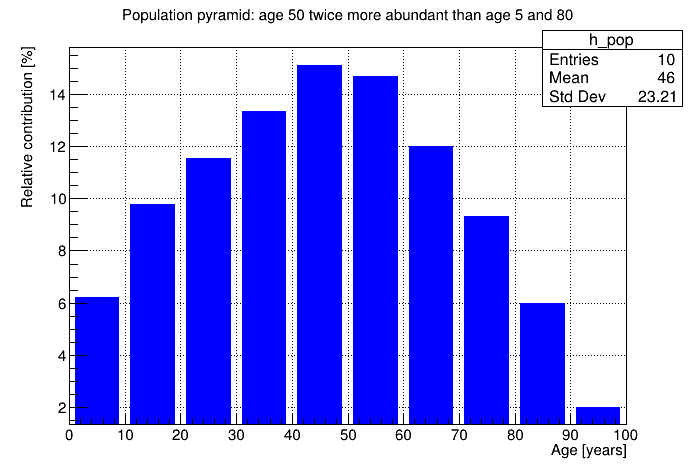

In [3]:
{
    // create actual distribution
    TF1 fpop("fpop", PopulationPyramid({ {5,1}, {50,2}, {80,1} }), 0, 100, 0);
    
    new TCanvas;
    TH1F *h_pop = new TH1F("h_pop", "Population pyramid: age 50 twice more abundant than age 5 and 80;Age [years];Relative contribution [%]", 10, 0, 100);
    for (int bin = 1; bin <= h_pop->GetNbinsX(); ++bin) {
        double w = fpop.Integral(h_pop->GetBinLowEdge(bin), h_pop->GetBinLowEdge(bin+1));
        h_pop->SetBinContent(bin, 100*w);
    }
    h_pop->SetFillColor(kBlue);
    h_pop->SetBarWidth(0.8);
    h_pop->SetBarOffset(0.1);
    h_pop->Draw("bar");
    gPad->SetGrid();
    gPad->Draw();
}

# Simulation setup
## Viral spread
The viral spread is governed by the transmission dynamics.  
For each person, the network of daily contacts is assumed to be a Erdős–Rényi random network (hence binomially distributed). If a person is infected, he/she will be able to expose $n$ persons according to his/her personal network. Each exposed person has a fixed probability of becoming infected.  
Infected people can not transmit the virus during the latent period, distributed log-normally. After the infectious period kicks in, a person can stay infected for a period of time, distributed log-normally.  
The commonly used reproduction number, $R_{0}$, is an effective parameter roughly equal to the average number of daily contacts $\times$ infection probability $\times$ infectious period duration.

The transmission dynamics can be updated during the simulation, allowing changes in the infection probability and personal network in response to mitigation and containment actions.  
The transmission dynamics can be different for different age categories.

## Disease development
Once a person is infected, the development of the disease is governed by the clinical dynamics.  
Some people will never have symptoms, or will have only very mild symptoms which are ignored. If this is not the case, the symptoms will show up after the incubation period, distributed log-normally.  
Once the symptoms appear, the severity of the disease is classified in three categories, each with its own probability:
* Mild: requires no hospitalization, full recovery guaranteed after a period distributed log-normally.
* Severe: requires hospitalization, but no ICU, and the recovery period is longer than for mild cases.
* Critical: requires ICU, long recovery period and possibly lead to death.

Only people in critical conditions can die, with a fixed probability defined as the conditional probability of dying after being recovered in ICU. Note that this probability can be very high, greater than 50%, but the fatality rate can still be around 1%, if the probability of developing a critical condition is low.

The clinical dynamics remains constant throughout the simulation, but if the number if critical cases exceed the number of ICU beds, then those cases have a death probability of 100%.  
The clinical dynamics can be different for different age categories.

## Testing
The testing process is crucial to find, isolate, and properly treat infected people, and is governed by the test dynamics.  
Unfortunately, resources are limited, so not all people can be tested, and a testing strategy needs to be defined. Here we assume the following strategies, depending on the severity of symptoms shown, and on how accurate contact tracing is:
* Test people with any kind of symptoms.
* Test people with only severe or critical symptoms.
* Test people with only critical symptoms.

Contact tracing, and subsequent testing, is treated as a single number between 0 and 1: 0 means no contact tracing is enforced (so only people with symptoms are tested), 1 means everybody in the network of daily contacts of the symptomatic person is identified and tested. Reality is somewhere in between, most likely below 0.5, except for South Korea.

Since no test is perfect, we allow for false positives and false negatives. For the sake of simplicity, we don't model any dependence of the test accuracy on the viral load.

The testing dynamics can be updated during the simulation, allowing changes to the strategy and contact tracing accuracy in response to mitigation and containment actions.

In [5]:
// probability density functions for various quantities are specified in square brackets
struct TransmissionDynamics {
    double InfectionProbability;             // [Bernoulli] Probability of becoming infected after exposure
    pair<double, double> PersonalContacts;   // [Binomial] Number of person an infected person is in contact with: { avg, std } => { n = 1/(avg-std^2), p = (avg-std^2)/avg }
    pair<double, double> LatentPeriod;       // [LogNormal] Period, in days, after which an infected person become infectious: { mu, sigma }
    pair<double, double> InfectiousDuration; // [LogNormal] Duration, in days, of the infectiouness period: { mu, sigma }
};

enum SymptomCategory {
    Mild, Severe, Critical
};

// probability density functions for various quantities are specified in square brackets
struct ClinicalDynamics {
    double AsymptomaticProbability;                    // [Bernoulli] Probability of *never* developing detectable symptoms
    pair<double, double> IncubationPeriod;             // [LogNormal] Period, in days, for symptom onset after infection: { mu, sigma }
    array<double, 3> CaseProbability;                  // [Bernoulli] Probability of having symptoms for each category
    array<pair<double, double>, 3> CaseRecoveryPeriod; // [LogNormal] Period, in days, before full recovery for each category: { mu, sigma }
    double DeathProbability;                           // [Bernoulli] Probability of dying, only if in critical case
};

struct TestDynamics {
    SymptomCategory Strategy; // only persons with symptom above threshold will be tested
    double ContactTracing;    // percentage of people in the personal network traced and tested
    double FalsePositiveRate; // percentage of tested people with no infection returning positive result
    double FalseNegativeRate; // percentage of tested people with infection returning negative result
};